In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time
import numpy as np
import pandas as pd

# BESOS
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import (
    Parameter,
    RangeParameter,
    FieldSelector,
    expand_plist,
    wwr,
    CategoryParameter,
    GenericSelector
)
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Visualización
import matplotlib.pyplot as plt
from seaborn import heatmap, pairplot
from plotly import express as px

# Scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings

from epw import epw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
building = ef.get_building("res-multifloor_IDF.idf")
epw_file='PARIS_FR-hour.epw'

In [4]:
meteo = epw()
meteo.read(epw_file)
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,13.459167,7.302180,67.973630,100858.916324,289.739269,...,99999.0,9.0,999999999.0,16.600685,0.174258,0.015183,74.213014,0.201285,0.051541,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,6.417562,5.387262,14.378834,272.243386,374.530939,...,0.0,0.0,0.0,6.329907,0.060578,0.184135,26.073199,0.017504,0.314345,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,-1.900000,-8.800000,27.000000,100069.000000,0.000000,...,99999.0,9.0,999999999.0,5.000000,0.039000,0.000000,0.000000,0.200000,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,8.700000,3.500000,57.000000,100661.000000,0.000000,...,99999.0,9.0,999999999.0,12.000000,0.126000,0.000000,76.000000,0.200000,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,13.200000,7.400000,68.000000,100849.000000,16.000000,...,99999.0,9.0,999999999.0,16.000000,0.181000,0.000000,88.000000,0.200000,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,18.300000,11.200000,79.000000,101066.000000,546.000000,...,99999.0,9.0,999999999.0,20.000000,0.218000,0.000000,88.000000,0.200000,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,33.200000,22.800000,100.000000,101547.000000,1190.000000,...,99999.0,9.0,999999999.0,46.000000,0.338000,3.000000,88.000000,0.607000,7.500000,99.0


In [5]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='MW Glass Wool (rolls)_.0001',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='_Insulation_.0001', 
                         field_name='Thickness')

wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.1,max_val=0.8)

insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]

In [6]:
ventAchRange = RangeParameter(min_val = 0.0, max_val=8.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))

In [7]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=5,max_val=20)

lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [8]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 100, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [9]:
parameters = insulation_param + ventilationAchParam + [lights_param] + setpointParams

In [10]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Ventilation ACH',
 'Lights Watts/Area',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [11]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)

In [12]:
initial_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=10) #Creates 20 samples to be evaluated with EnergyPlus, these are going to
#be te 20 initial points for the FuzzyLolaVoronoi sampler from Harlow

In [13]:
t1 = time.time()
# Run Energyplus
initial_samples = evaluator.df_apply(initial_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/10 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [14]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours 19 min 22 seconds


In [15]:
initial_samples.to_pickle("simulation_initial_points_example_2_20.pkl")

input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

In [16]:
initial_points_x = initial_samples[input_cols].values.astype(float)  
initial_points_y = initial_samples[output_cols].values.astype(float)  

In [17]:
test_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=5) 

In [18]:
t1 = time.time()
# Run Energyplus
test_samples = evaluator.df_apply(test_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/5 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [19]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  9 min 57 seconds


In [20]:
test_samples.to_pickle("simulation_test_points_example_2_5.pkl")

test_x = test_samples[input_cols].values.astype(float)
test_y = test_samples[output_cols].values.astype(float)

In [21]:
#this is the first scaling, this is needed in order for harlow to work

scaler = StandardScaler()
initial_points_x_scale = scaler.fit_transform(X=initial_points_x)
test_x_scale = scaler.transform(X=test_x)

scaler_out = StandardScaler()
initial_points_y_scale = scaler_out.fit_transform(X=initial_points_y)
test_y_scale = scaler_out.transform(X=test_y)

In [25]:
# this are the bounds for harlow, please verify that are the same and in the same order as the parameters you created with besos
import numpy as np

# Bounds originales
domain_lower_bound = np.array([0.1,  0.1, 0.0,  5, 18,  100], dtype=float)
domain_upper_bound = np.array([0.5,  0.8, 8.0, 20, 30, 300], dtype=float)

# Scaling bounds is also necessary, use the same scaler that you used for the inputs in tis case "scaler"
scaled_lower_bound = scaler.transform(domain_lower_bound.reshape(1, -1)).ravel()
scaled_upper_bound = scaler.transform(domain_upper_bound.reshape(1, -1)).ravel()

print("Scaled lower bounds:", scaled_lower_bound)
print("Scaled upper bounds:", scaled_upper_bound)

Scaled lower bounds: [-1.66567014 -1.69834372 -2.8410182   0.45143018 -1.76772585 -1.74493321]
Scaled upper bounds: [ 1.69918484  1.80585549 -1.01546525  7.02895303  1.67919377  1.681888  ]


In [26]:
input_cols  = list(initial_points_x.columns)  if hasattr(initial_points_x, 'columns')  else [f'x{i}' for i in range(initial_points_x.shape[1])]
output_cols = list(initial_points_y.columns)  if hasattr(initial_points_y, 'columns') else ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

def target_f(x):
    """
    This function is the most important part when coupling EnergyPlus besos evaluator for it to work with harlow, this takes the new point 
    generated by harlow each adaptive iteration, descales it, reshapes it to the form the evaluator need it in order to work, then the evaluation is
    done and the output is again scaled and returned in order for harlow to work, please use the same scalers.
    """
    # 1) Reshape to a numpy 2D
    x_arr = np.array(x, dtype=float)
    if x_arr.ndim == 1:
        x_arr = x_arr.reshape(1, -1)

    # 2) Descaling to original values
    x_orig = scaler.inverse_transform(x_arr)

    # 3) evaluates next point with BESOS/EPEvaluator
    df_in = pd.DataFrame(x_orig, columns=input_cols)
    df_out = evaluator.df_apply(df_in)
    y_orig = df_out[output_cols].values.astype(float)

    # 4) Scaling the output again for harlow
    y_scaled = scaler_out.transform(y_orig)

    return y_scaled

In [27]:
#necessary inputs from harlow for this example we will employ 
#LolaVoronoi sampler
#BatchIndependentGaussianProcess surrogate for estimating loss and new better points

import os
import numpy as np
from harlow.surrogating.surrogate_model import BatchIndependentGaussianProcess
from harlow.sampling import FuzzyLolaVoronoi

# Defining a custom RMSE for multi output, used for stopping criteria
def rmse_multi(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))

surrogate_model = BatchIndependentGaussianProcess

# Initializing the adaptive sampler
adaptive_samples = FuzzyLolaVoronoi(
    target_function    = target_f,
    surrogate_model    = surrogate_model,
    domain_lower_bound = scaled_lower_bound,
    domain_upper_bound = scaled_upper_bound,
    fit_points_x       = initial_points_x_scale,
    fit_points_y       = initial_points_y_scale,
    test_points_x      = test_x_scale,
    test_points_y      = test_y_scale,
    evaluation_metric  = rmse_multi
)

# patch for obtaining a 2D array
_orig_update = adaptive_samples.surrogate_model.update

def _update_force2d(X, y, **kwargs):
    y_arr = np.array(y, dtype=float)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(1, -1)
    return _orig_update(X, y_arr, **kwargs)
adaptive_samples.surrogate_model.update = _update_force2d

# Executes adaptive sampling
adaptive_samples.sample(
    n_initial_points           = initial_points_x.shape[0],
    max_n_iterations           = 20,
    n_new_points_per_iteration = 1,
    stopping_criterium         = [0.01]
)

Iter = 99 / 100, Loss = 1.1566684246063232, Loss_ratio = None

2025-05-23 05:42:57.000 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:126 - Fitted the first surrogate model in 0.2963240146636963 sec.
2025-05-23 05:42:57.006 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 1 (max steps: 20).


Iter = 100, Loss = 1.1566684246063232, Loss_ratio = None


2025-05-23 05:42:57.062 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.055011749267578125 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1886407136917114, Loss_ratio = None

2025-05-23 05:45:02.560 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.27649545669555664 sec.
2025-05-23 05:45:02.569 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 2 (max steps: 20).


Iter = 100, Loss = 1.1886407136917114, Loss_ratio = None


2025-05-23 05:45:02.644 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.07381558418273926 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2103872299194336, Loss_ratio = None

2025-05-23 05:47:09.485 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2932403087615967 sec.
2025-05-23 05:47:09.489 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 3 (max steps: 20).


Iter = 100, Loss = 1.2103872299194336, Loss_ratio = None


2025-05-23 05:47:09.630 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.13916325569152832 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.2068291902542114, Loss_ratio = None

2025-05-23 05:49:09.919 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2537994384765625 sec.
2025-05-23 05:49:09.924 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 4 (max steps: 20).


Iter = 100, Loss = 1.2068291902542114, Loss_ratio = None


2025-05-23 05:49:10.106 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.18173432350158691 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.18208909034729, Loss_ratio = Nonene

2025-05-23 05:51:07.530 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2718071937561035 sec.
2025-05-23 05:51:07.536 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 5 (max steps: 20).


Iter = 100, Loss = 1.18208909034729, Loss_ratio = None


2025-05-23 05:51:07.717 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.18009710311889648 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1672494411468506, Loss_ratio = None

2025-05-23 05:53:11.591 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2759888172149658 sec.
2025-05-23 05:53:11.597 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 6 (max steps: 20).


Iter = 100, Loss = 1.1672494411468506, Loss_ratio = None


2025-05-23 05:53:11.838 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.24022650718688965 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1923197507858276, Loss_ratio = None

2025-05-23 05:55:15.580 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2794506549835205 sec.
2025-05-23 05:55:15.586 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 7 (max steps: 20).


Iter = 100, Loss = 1.1923197507858276, Loss_ratio = None


2025-05-23 05:55:15.839 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2518274784088135 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1815900802612305, Loss_ratio = None

2025-05-23 05:57:10.569 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.27666354179382324 sec.
2025-05-23 05:57:10.576 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 8 (max steps: 20).


Iter = 100, Loss = 1.1815900802612305, Loss_ratio = None


2025-05-23 05:57:10.849 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2725074291229248 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1403405666351318, Loss_ratio = None

2025-05-23 05:59:06.506 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2699415683746338 sec.
2025-05-23 05:59:06.512 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 9 (max steps: 20).


Iter = 100, Loss = 1.1403405666351318, Loss_ratio = None


2025-05-23 05:59:06.819 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.3066229820251465 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.1188281774520874, Loss_ratio = None

2025-05-23 06:01:02.424 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2818450927734375 sec.
2025-05-23 06:01:02.435 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 10 (max steps: 20).


Iter = 100, Loss = 1.1188281774520874, Loss_ratio = None


2025-05-23 06:01:02.772 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.3360118865966797 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.088442087173462, Loss_ratio = Nonee

2025-05-23 06:03:08.930 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2578911781311035 sec.
2025-05-23 06:03:08.935 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 11 (max steps: 20).


Iter = 100, Loss = 1.088442087173462, Loss_ratio = None


2025-05-23 06:03:09.380 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.4446220397949219 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0505212545394897, Loss_ratio = None

2025-05-23 06:05:17.265 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2900416851043701 sec.
2025-05-23 06:05:17.270 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 12 (max steps: 20).


Iter = 100, Loss = 1.0505212545394897, Loss_ratio = None


2025-05-23 06:05:17.687 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.41672205924987793 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 1.0144646167755127, Loss_ratio = None

2025-05-23 06:07:15.319 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.27019786834716797 sec.
2025-05-23 06:07:15.324 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 13 (max steps: 20).


Iter = 100, Loss = 1.0144646167755127, Loss_ratio = None


2025-05-23 06:07:15.830 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5056734085083008 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.9685961008071899, Loss_ratio = None

2025-05-23 06:09:12.668 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3185863494873047 sec.
2025-05-23 06:09:12.673 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 14 (max steps: 20).


Iter = 100, Loss = 0.9685961008071899, Loss_ratio = None


2025-05-23 06:09:13.165 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.49121642112731934 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.9471496939659119, Loss_ratio = None

2025-05-23 06:11:06.401 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.270831823348999 sec.
2025-05-23 06:11:06.406 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 15 (max steps: 20).


Iter = 100, Loss = 0.9471496939659119, Loss_ratio = None


2025-05-23 06:11:06.934 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5283331871032715 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.930133044719696, Loss_ratio = Nonee

2025-05-23 06:13:07.304 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29131293296813965 sec.
2025-05-23 06:13:07.309 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 16 (max steps: 20).


Iter = 100, Loss = 0.930133044719696, Loss_ratio = None


2025-05-23 06:13:07.864 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5535078048706055 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.9142985343933105, Loss_ratio = None

2025-05-23 06:15:00.182 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.28986144065856934 sec.
2025-05-23 06:15:00.187 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 17 (max steps: 20).


Iter = 100, Loss = 0.9142985343933105, Loss_ratio = None


2025-05-23 06:15:00.839 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6507706642150879 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.9026831984519958, Loss_ratio = None

2025-05-23 06:16:55.188 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2919905185699463 sec.
2025-05-23 06:16:55.193 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 18 (max steps: 20).


Iter = 100, Loss = 0.9026831984519958, Loss_ratio = None


2025-05-23 06:16:55.849 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6548476219177246 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8819445371627808, Loss_ratio = None

2025-05-23 06:18:53.741 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.31827402114868164 sec.


Iter = 100, Loss = 0.8819445371627808, Loss_ratio = None


2025-05-23 06:18:53.748 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 19 (max steps: 20).
2025-05-23 06:18:54.455 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7061381340026855 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8799589276313782, Loss_ratio = None

2025-05-23 06:20:46.724 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2805616855621338 sec.
2025-05-23 06:20:46.729 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 20 (max steps: 20).


Iter = 100, Loss = 0.8799589276313782, Loss_ratio = None


2025-05-23 06:20:47.503 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7730395793914795 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.8652829527854919, Loss_ratio = None

2025-05-23 06:22:45.929 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.28053832054138184 sec.


Iter = 100, Loss = 0.8652829527854919, Loss_ratio = None


(array([[-0.57903015, -0.4714138 , -0.11432035,  0.83928397,  1.27557538,
         -0.21897212],
        [ 1.05312955, -1.30266346, -1.21919465,  0.06032949, -0.11739989,
          1.58268215],
        [ 0.94480863,  1.03786998, -0.57552148, -1.18158106,  1.42917875,
          0.21386665],
        [-1.62438227,  0.54912116,  0.38623097,  1.11116076,  0.37649519,
          0.63011753],
        [ 0.43012748,  1.22037157,  1.50109888, -0.66426206, -1.33203085,
          1.25774524],
        [-1.16030522,  1.45554882,  1.36761325,  1.68818303, -0.44937653,
         -0.45737224],
        [-0.88559094,  0.15052351,  0.14465728,  0.7011539 ,  0.97747959,
         -1.36787601],
        [ 0.23622908, -1.46264347,  0.9044475 , -0.26096001, -1.5251052 ,
         -1.42663118],
        [-0.04320635, -0.93468656, -0.88973854, -0.84615697, -0.91560156,
         -0.90806138],
        [ 1.62822019, -0.24202775, -1.50527287, -1.44715106,  0.28078513,
          0.69450136],
        [ 0.77493847, -1.61215

In [28]:
#first descaling of adaptive objects, we do this in order to see the real distribution of samples so here the vizualization of the data starts
input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

X_adaptive = adaptive_samples.fit_points_x    
Y_adaptive = adaptive_samples.fit_points_y    

df_adaptive_samples = pd.DataFrame(X_adaptive, columns=input_cols)
for i, col in enumerate(output_cols):
    df_adaptive_samples[col] = Y_adaptive[:, i]

outputs = df_adaptive_samples.drop(input_cols, axis=1)
inputs = df_adaptive_samples.drop(objectives, axis=1)

outputs_original = scaler_out.inverse_transform(outputs)
inputs_original = scaler.inverse_transform(inputs)

outputs_original_df=pd.DataFrame(outputs_original, columns=objectives)
inputs_original_df=pd.DataFrame(inputs_original, columns=input_cols)

samples_original_df = pd.concat([inputs_original_df,outputs_original_df], axis=1)

In [29]:
samples_original_df.to_pickle("adaptive_samples_example_2_40.pkl") #saving the EP runs input - output rows(could save you a lot of time)

In [30]:
samples_original_df.describe()

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01
mean,0.312577,0.447548,6.453522,10.361565,24.076689,199.487892,6.238258e+10,1.063619e+11,6.763974e+09
std,0.144190,0.248695,5.606662,6.065209,4.298739,72.228749,5.644376e+09,4.120003e+09,4.490749e+09
min,0.104908,0.102707,0.117951,0.670297,18.009922,101.196472,5.304940e+10,9.837688e+10,1.601456e+09
25%,0.157151,0.223804,1.099015,5.718877,19.597840,122.434491,5.833974e+10,1.037104e+11,2.425645e+09
50%,0.333899,0.387199,6.464530,10.159179,25.298224,218.337913,6.210377e+10,1.063739e+11,6.407793e+09
75%,0.449654,0.691023,8.410502,15.056050,28.212251,259.121670,6.785339e+10,1.082645e+11,1.145669e+10
max,0.499820,0.796878,19.028173,19.917641,29.954862,295.947887,7.072516e+10,1.144661e+11,1.355892e+10


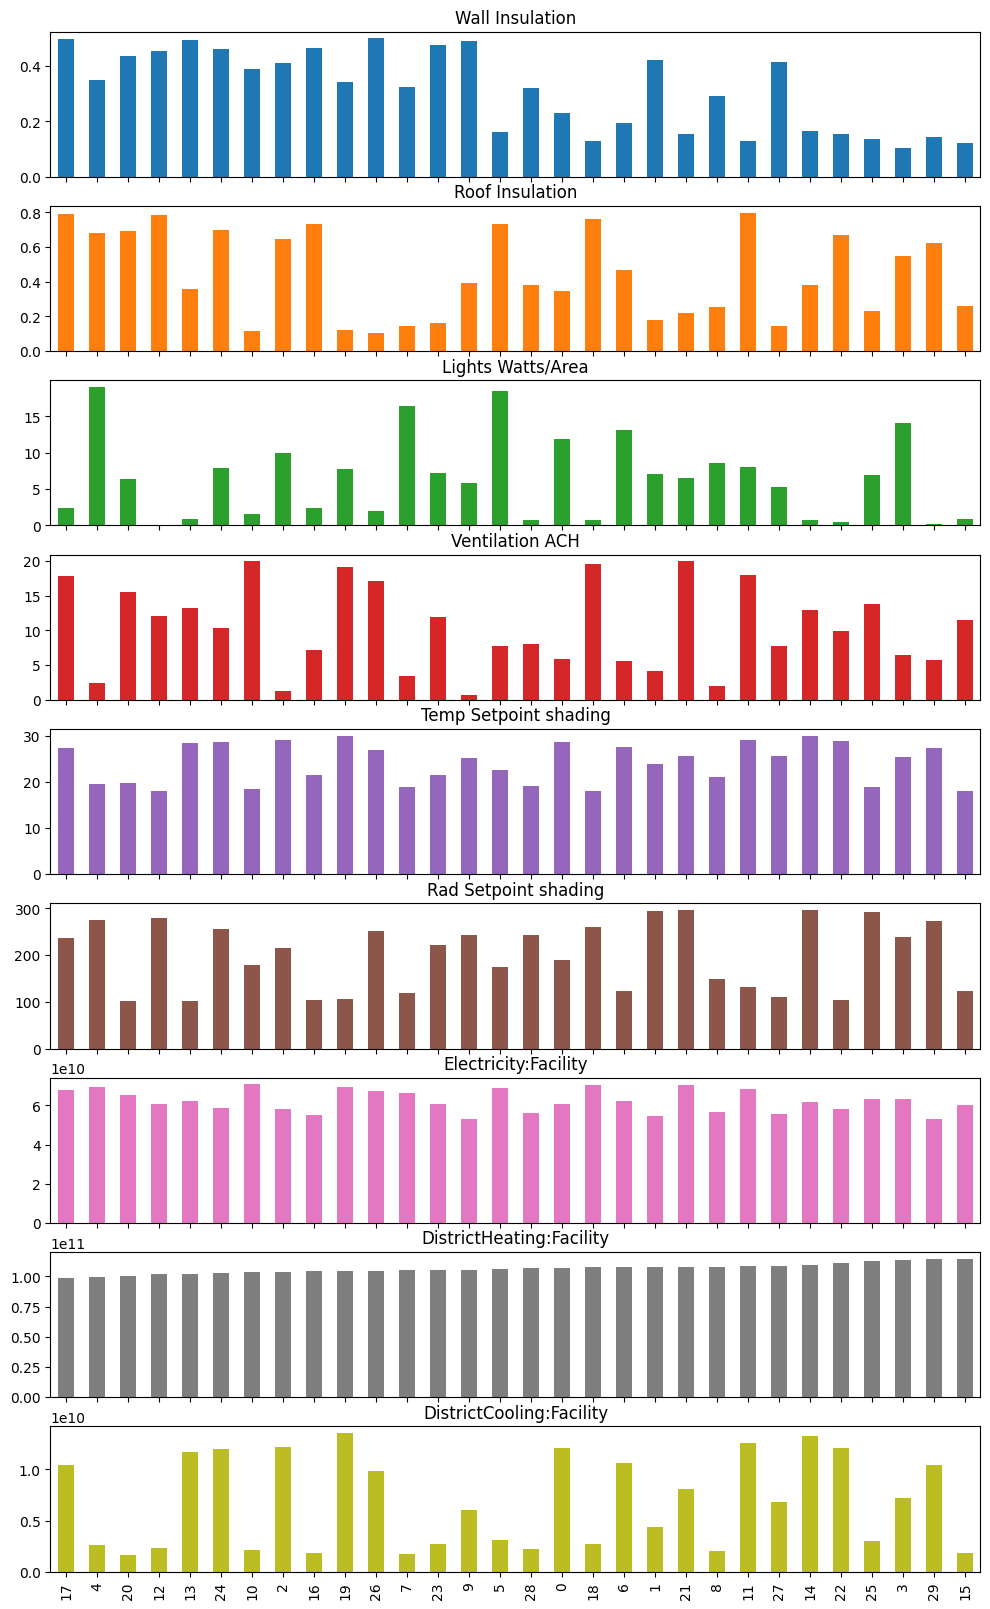

In [31]:
samples_original_df = samples_original_df.sort_values(by=output_cols[1])
ax=samples_original_df.plot.bar(subplots=True,legend=None, figsize=(12,20))

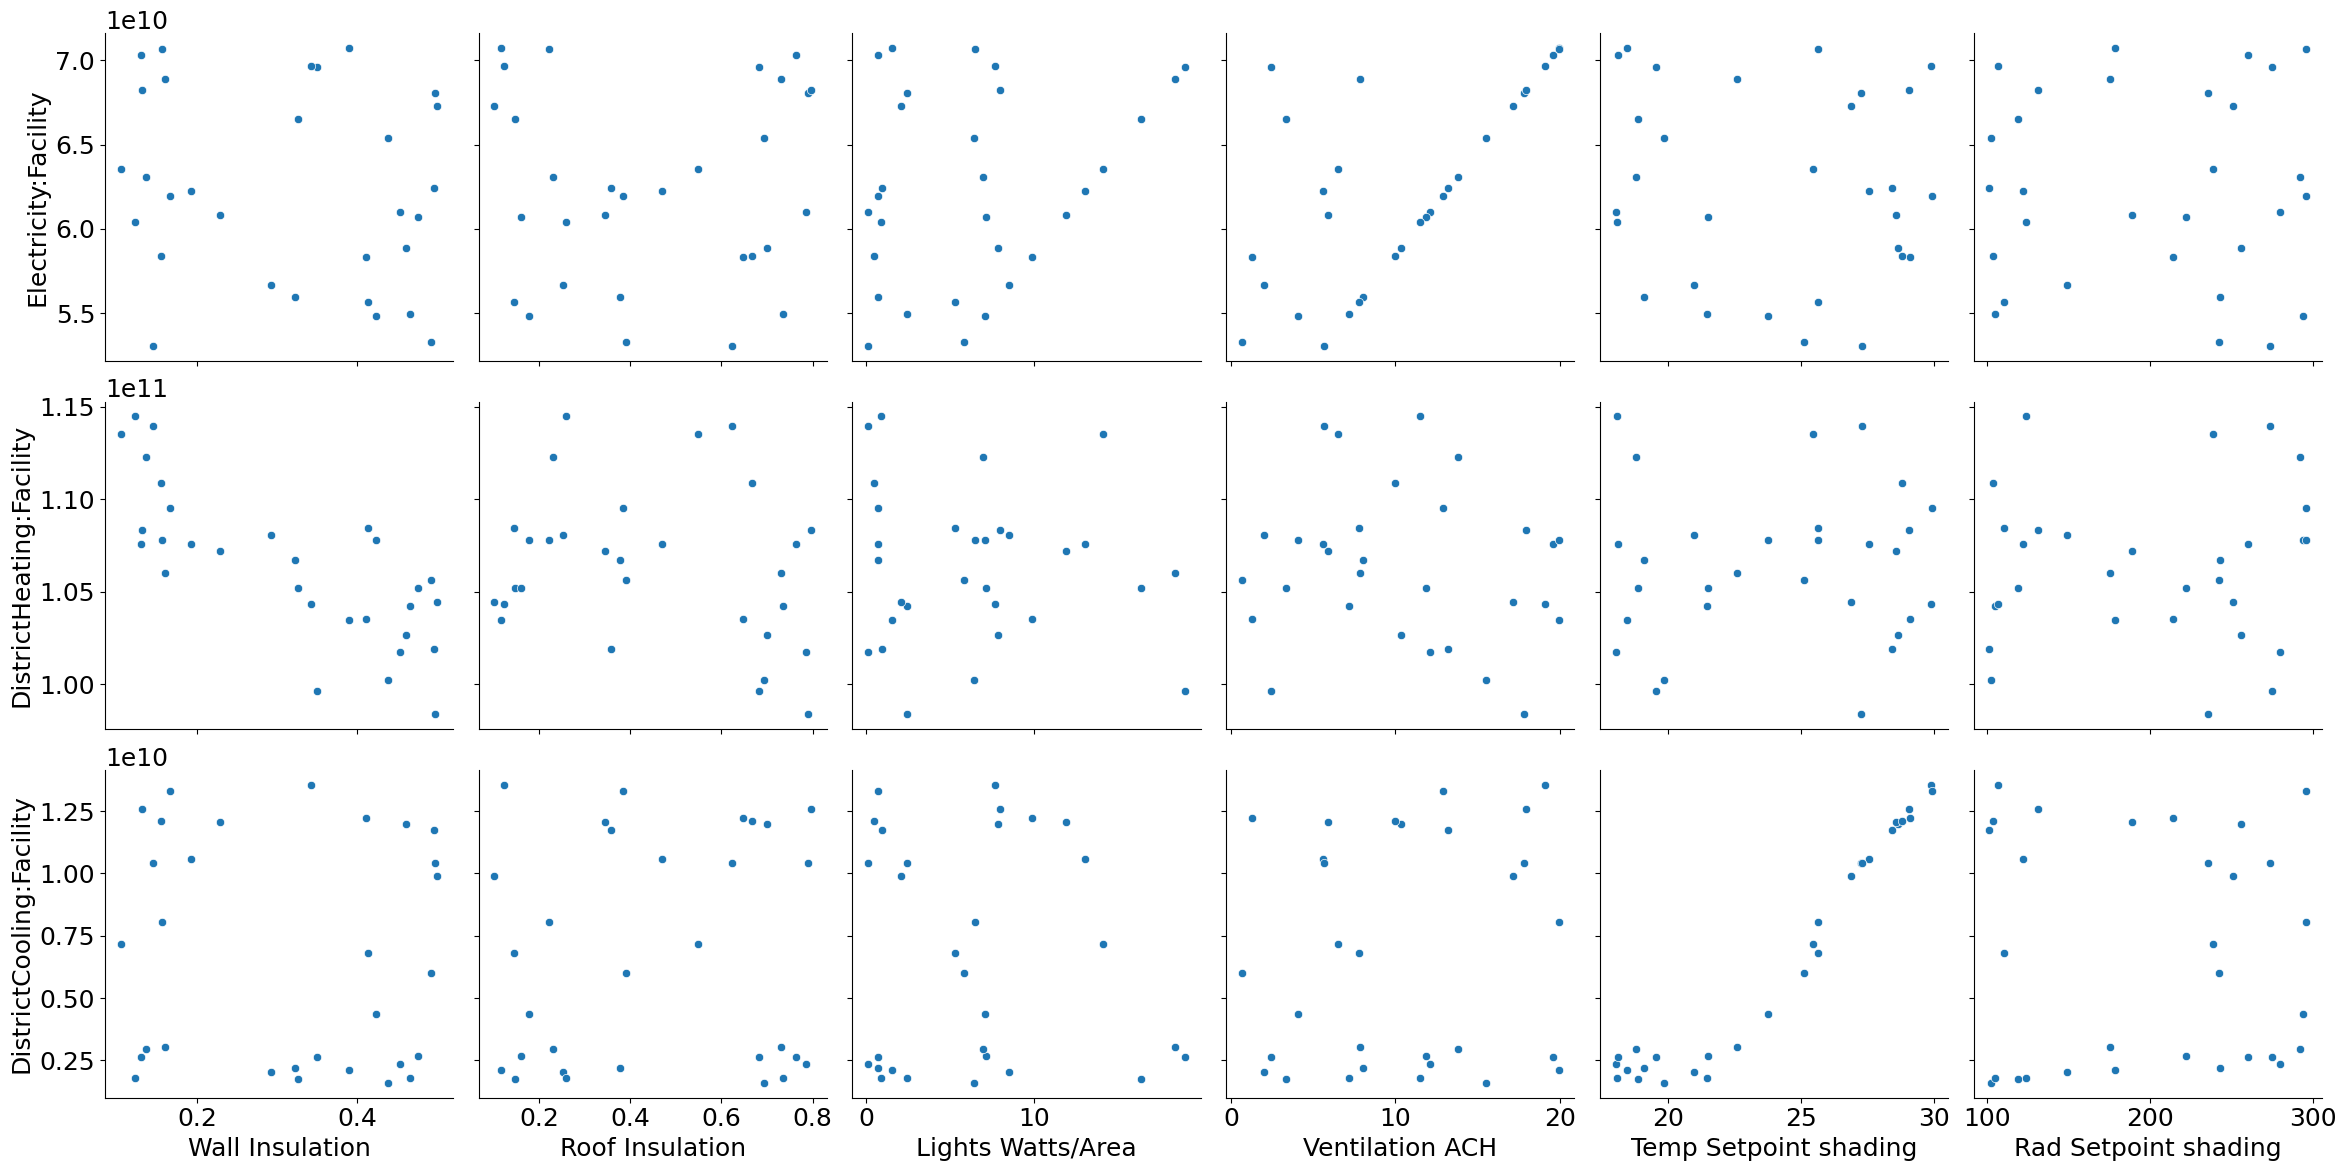

In [32]:
plt.rcParams.update({'font.size': 18})
_=pairplot(samples_original_df,x_vars=input_cols, y_vars=objectives, kind="scatter",height=4)

In [33]:
corr=samples_original_df.corr()
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,-0.103102,-0.150896,-0.070303,-0.015989,-0.056554,-0.190282,-0.767469,-0.089281
Roof Insulation,-0.103102,1.000000,0.021891,-0.038736,0.068822,0.048153,0.028434,-0.229944,0.094234
Lights Watts/Area,-0.150896,0.021891,1.000000,-0.459273,-0.001994,-0.075228,0.266747,-0.106874,-0.082765
Ventilation ACH,-0.070303,-0.038736,-0.459273,1.000000,0.010282,0.010252,0.652069,-0.132313,0.134085
Temp Setpoint shading,-0.015989,0.068822,-0.001994,0.010282,1.000000,-0.080233,-0.108937,0.047619,0.962970
Rad Setpoint shading,-0.056554,0.048153,-0.075228,0.010252,-0.080233,1.000000,-0.001179,0.059608,-0.034336
Electricity:Facility,-0.190282,0.028434,0.266747,0.652069,-0.108937,-0.001179,1.000000,-0.312785,-0.000212
DistrictHeating:Facility,-0.767469,-0.229944,-0.106874,-0.132313,0.047619,0.059608,-0.312785,1.000000,0.050399
DistrictCooling:Facility,-0.089281,0.094234,-0.082765,0.134085,0.962970,-0.034336,-0.000212,0.050399,1.000000


In [34]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.190282,0.028434,0.266747,0.652069,-0.108937,-0.001179
DistrictHeating:Facility,-0.767469,-0.229944,-0.106874,-0.132313,0.047619,0.059608
DistrictCooling:Facility,-0.089281,0.094234,-0.082765,0.134085,0.962970,-0.034336


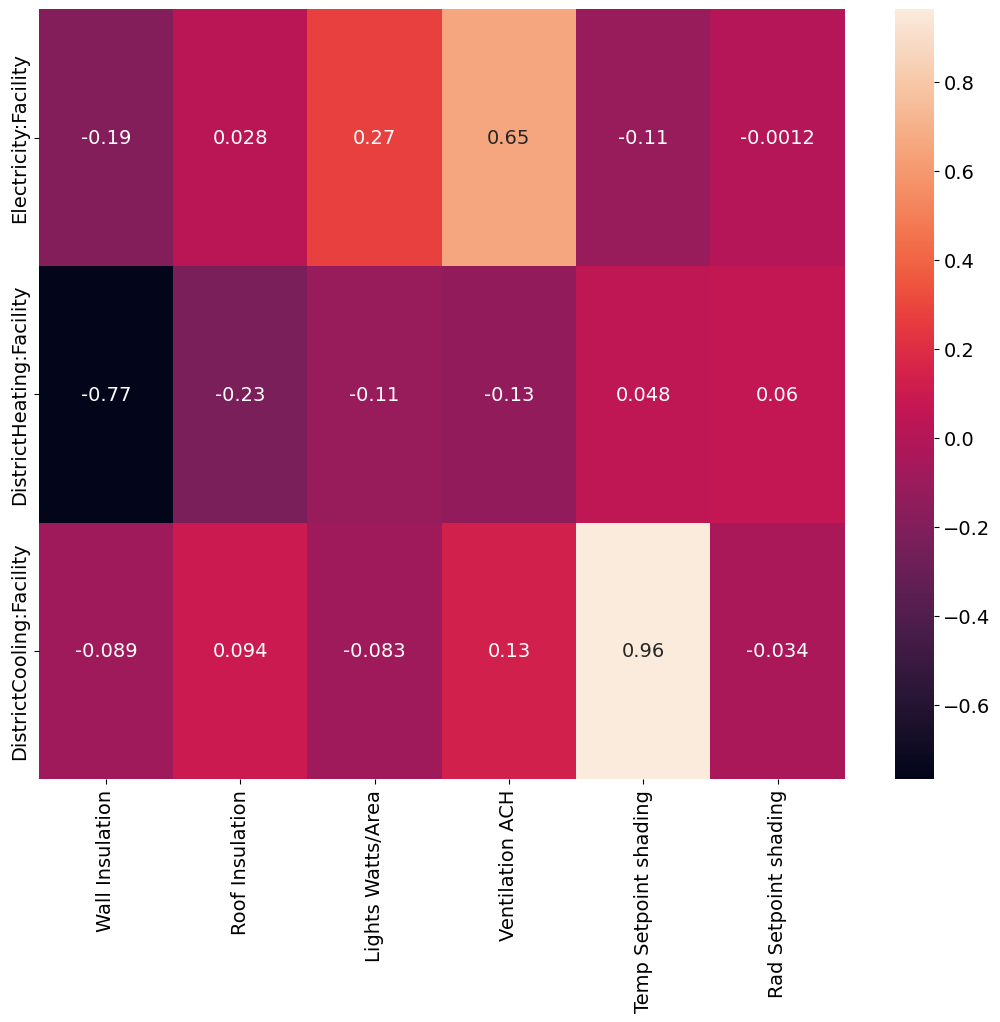

In [35]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [36]:
train_in, test_in, train_out, test_out = train_test_split(
    inputs_original_df, outputs_original_df, test_size=0.2
)

In [37]:
#second scaling we turn again the original samples in to scaled dataset to train and test surrogate models

scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [38]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

In [39]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [40]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,515 (17.64 KB)

 Trainable params: 4,515 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [41]:
mse = mean_squared_error(prediction_gp,
                         test_out.values,
                         multioutput='raw_values')

# 2) RMSE
rmse = np.sqrt(mse)

mean_vals = test_out.mean().values
rmse_pct = rmse / mean_vals * 100


print("GP:")
print("RMSE:", rmse)
print("RMSE %:", rmse_pct)

GP:
RMSE: [2.14241521e+09 2.99399319e+09 1.10902557e+09]
RMSE %: [ 3.33055682  2.72999679 13.24335377]


In [42]:
mse_nn = mean_squared_error(
    prediction_nn,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_nn = np.sqrt(mse_nn)

mean_vals = test_out.mean().values
rmse_pct_nn = rmse_nn / mean_vals * 100

print("NN:")
print("RMSE NN:", rmse_nn)
print("RMSE % NN:", rmse_pct_nn)

NN:
RMSE NN: [2.03001955e+09 2.32241610e+09 6.74825286e+08]
RMSE % NN: [3.15582872 2.11763625 8.05838048]


In [43]:
mse_tf = mean_squared_error(
    prediction_tf,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_tf = np.sqrt(mse_tf)

mean_vals = test_out.mean().values
rmse_pct_tf = rmse_tf / mean_vals * 100


print("TF:")
print("RMSE TensorFlow:", rmse_tf)
print("RMSE % TensorFlow:", rmse_pct_tf)

TF:
RMSE TensorFlow: [3.03253676e+09 1.91754197e+09 1.85230340e+09]
RMSE % TensorFlow: [ 4.71432239  1.74846203 22.11915564]


In [44]:
parameters = insulation_param + [lights_param]  + ventilationAchParam + setpointParams

objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [45]:
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(best_gp.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.151912,0.553514,4.947749,8.652464,22.261410,134.747092,5.952589e+10,1.114305e+11,4.070813e+09
1,0.195003,0.268519,2.440569,19.838077,23.194346,203.463611,6.794289e+10,1.088890e+11,7.324351e+09
2,0.450560,0.617993,3.032357,6.901703,28.460839,195.329615,5.991447e+10,1.061391e+11,9.422183e+09
3,0.179393,0.667010,5.132713,6.529075,23.596936,236.051314,5.935336e+10,1.098047e+11,6.373262e+09
4,0.262323,0.640200,3.565382,7.349413,21.284071,146.051247,5.820738e+10,1.091038e+11,2.609974e+09


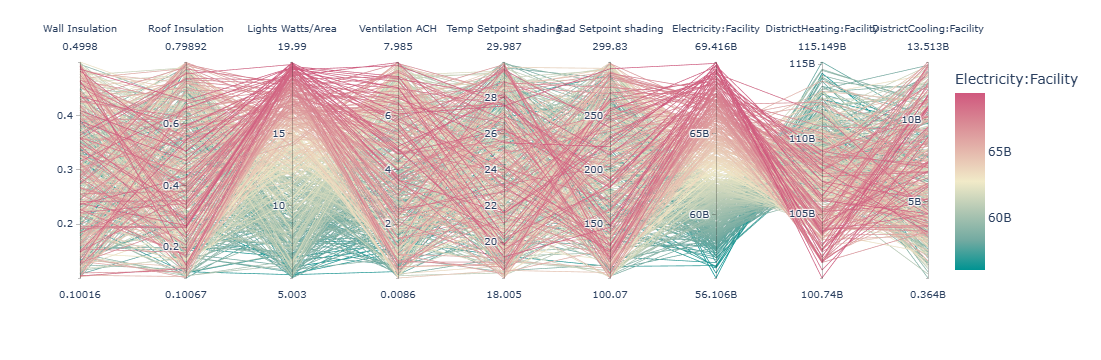

In [46]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

features = input_cols
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [47]:
from platypus import Problem, Real, NSGAII
import numpy as np

# 1) Número de variables y de objetivos
d = len(features)
m = len(objectives)

# 2) Monta el problema Platypus “a mano”
plat_prob = Problem(d, m)
plat_prob.types[:] = [
    Real(param.value_descriptor.min, param.value_descriptor.max)
    for param in parameters
]
plat_prob.function = lambda xs: tuple(evaluation_func(xs))

# 3) Corre NSGA-II
algo = NSGAII(plat_prob, population_size=10000)
algo.run(5000)

# 4) Saca tu frente Pareto
pareto = algo.result
objectives_array = np.array([sol.objectives for sol in pareto])

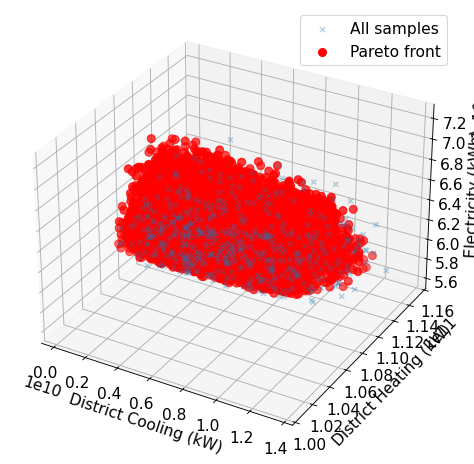

In [48]:
pareto_sols = algo.result
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])

# 2) Montar DataFrame de Pareto con las mismas columnas que srresults
opt_df = pd.DataFrame(
    np.hstack([X_pareto, Y_pareto]),
    columns=features + objectives
)

# 3) Graficar todo el muestreo inicial y el frente Pareto en 3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax  = fig.add_subplot(111, projection='3d')

# Muestreo inicial en azul con cruces
ax.scatter(
    srresults["DistrictCooling:Facility"],
    srresults["DistrictHeating:Facility"],
    srresults["Electricity:Facility"],
    marker='x', alpha=0.3, label='All samples'
)

# Frontera de Pareto en rojo con círculos
ax.scatter(
    opt_df["DistrictCooling:Facility"],
    opt_df["DistrictHeating:Facility"],
    opt_df["Electricity:Facility"],
    c='r', marker='o', s=50, label='Pareto front'
)

ax.set_xlabel("District Cooling (kW)")
ax.set_ylabel("District Heating (kW)")
ax.set_zlabel("Electricity (kWh)")
ax.legend()
plt.tight_layout()
plt.show()

In [49]:
opt_df

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.172777,0.627347,15.612969,2.918585,29.698862,280.564901,6.665300e+10,1.067127e+11,1.255165e+10
1,0.452186,0.719862,9.808940,2.030838,26.734496,176.230610,6.276092e+10,1.047059e+11,8.160992e+09
2,0.349779,0.560137,10.232616,1.244328,27.855205,217.876564,6.267239e+10,1.061226e+11,9.528522e+09
3,0.384364,0.383119,14.055142,6.530454,29.881307,147.100936,6.521148e+10,1.053641e+11,1.138039e+10
4,0.297809,0.260733,14.111464,0.012825,27.713891,104.308340,6.463466e+10,1.075257e+11,9.351725e+09
...,...,...,...,...,...,...,...,...,...
9995,0.419633,0.403479,15.877248,5.860599,21.223715,223.866356,6.677480e+10,1.040881e+11,4.780568e+09
9996,0.456860,0.163001,13.097207,5.010622,20.750103,276.073560,6.425658e+10,1.064958e+11,3.773832e+09
9997,0.422877,0.696983,11.742897,0.971090,28.398065,207.566776,6.387613e+10,1.046004e+11,9.927857e+09
9998,0.172068,0.266327,5.471756,7.211622,21.762851,272.798542,5.929316e+10,1.112286e+11,4.049954e+09


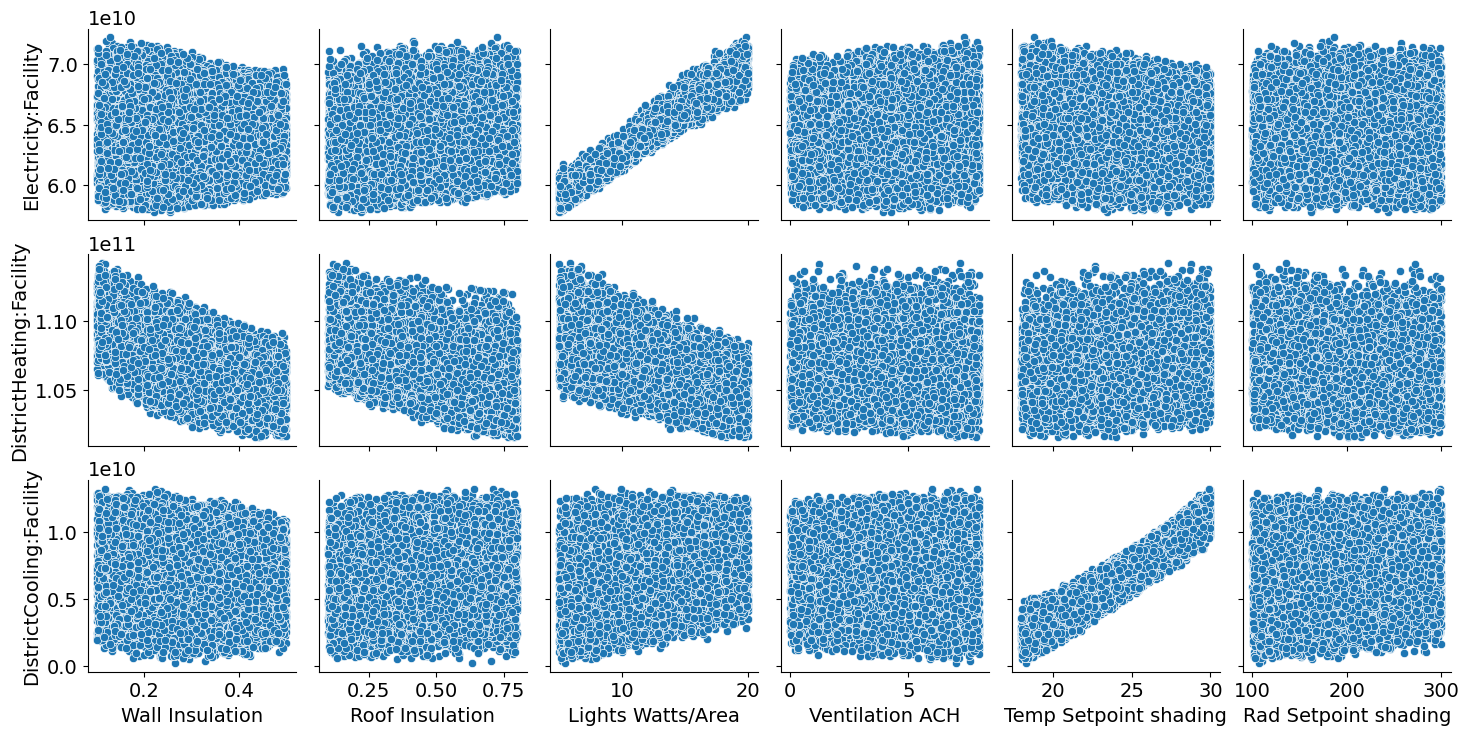

In [50]:
_=pairplot(opt_df,x_vars=input_cols, y_vars=objectives, kind="scatter")

In [51]:
pareto_sols = algo.result  # o NSGAII(...) según tu opción B
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])
opt_df = pd.DataFrame(np.hstack([X_pareto, Y_pareto]), columns=features + objectives)

In [52]:
corr=opt_df.corr()

corr.drop(objectives, axis = 1, inplace = True)
corr.drop(features, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.090826,0.107076,0.970240,0.070727,-0.107510,0.005490
DistrictHeating:Facility,-0.602990,-0.445054,-0.599867,-0.045152,0.119201,-0.085801
DistrictCooling:Facility,-0.112367,0.068328,0.213826,-0.027817,0.951871,0.082496


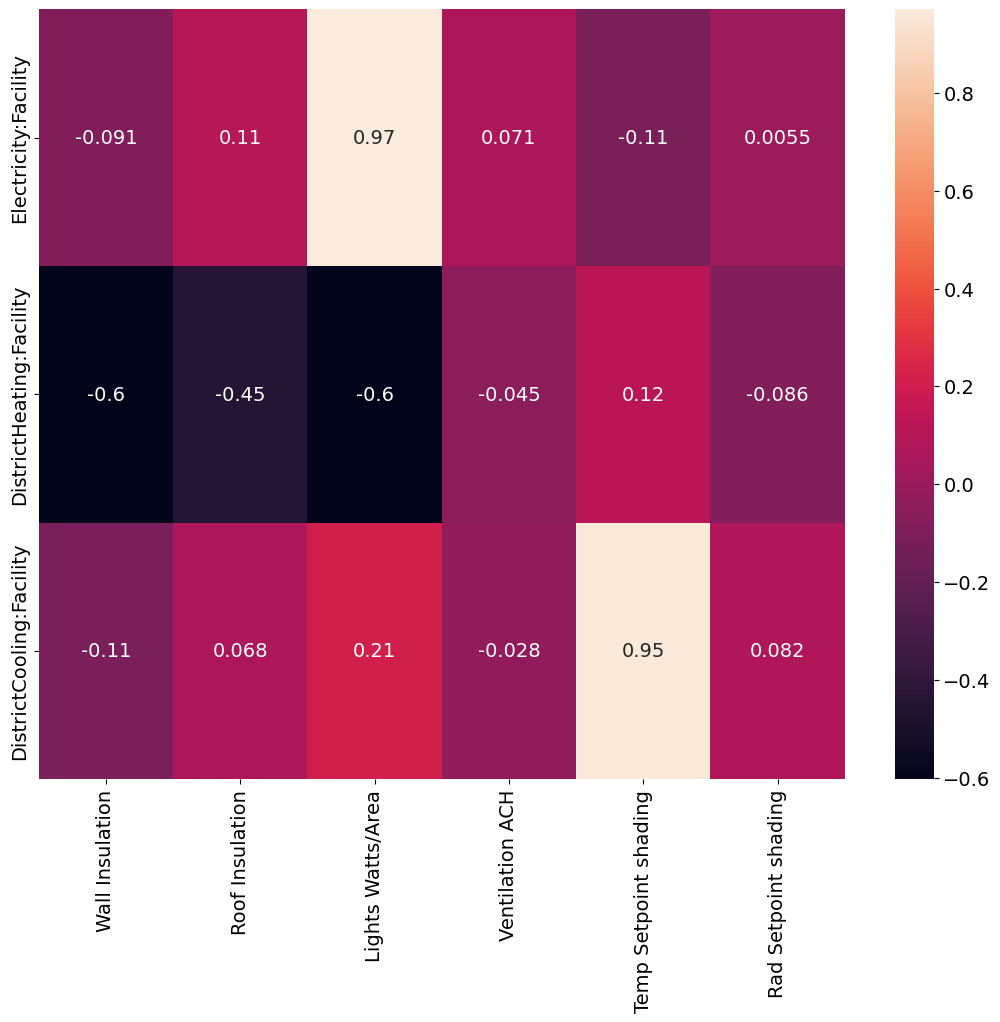

In [53]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [54]:
opt_df['Total'] = opt_df['Electricity:Facility'] + opt_df['DistrictHeating:Facility'] + opt_df['DistrictCooling:Facility']
opt_df['Dist'] = opt_df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

opt_df[opt_df.Dist == opt_df.Dist.min()]

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
8738,0.485403,0.710482,5.314931,7.571376,20.691374,251.031313,6.146532e+10,1.045783e+11,4.025942e+09,1.700696e+11,1.213706e+11


In [55]:
optimal_params=opt_df.loc[opt_df.Dist == opt_df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.48540316302337716,
 'Roof Insulation': 0.7104824152751062,
 'Lights Watts/Area': 5.314931362639145,
 'Ventilation ACH': 7.571375651543721,
 'Temp Setpoint shading': 20.691374452503062,
 'Rad Setpoint shading': 251.0313128618874}